In [1]:
mounted = False
try:
    import google.colab
    from google.colab import drive
    IN_COLAB = True
except:
    IN_COLAB = False

def mount_drive():
    global mounted
    drive.mount("/content/drive", force_remount=True)
    mounted = True

def open_dataset(filepath):
    if IN_COLAB:
        filepath = '/content/drive/My Drive/UNI/CE101/{}'.format(filepath)
        if not mounted:
            mount_drive()
    data = pd.read_csv(filepath)
    return data

def scatter(y, x):
    fig, ax = plt.subplots()
    ax.scatter(x = train_dataset[x], y = train_dataset[y])
    plt.ylabel(y)
    plt.xlabel(x)
    plt.show()
    
def boxplot(x,y):
    sns.boxplot(x=train_dataset[x].sort_values(), y=train_dataset[y])
      

import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import norm, skew
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder



The below code loads both of the data files provided using the Pandas method pd.read_csv

This formats the data into the dataframes datastructure which allows for easy manipulation of data.

In [2]:
train_dataset = open_dataset("train.csv")
test_dataset = open_dataset("test.csv")

# Exploratory Data Analysis

to begin to understand the problem that needs to be solved, it is important to explore and understand the data. The first variable that needs to be identified is the target variable, which is the variable that the machine leaning model will be predicting.


# The sale price: 

In [3]:
train_dataset['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The description of the sales price column lists some important facts, such as the mininum price being above 0, which is what you'd expect.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


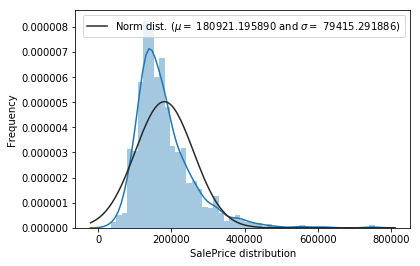

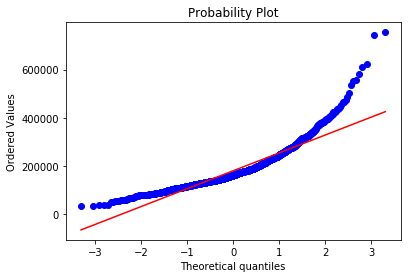

In [4]:
sns.distplot(train_dataset['SalePrice'], fit=norm);

(mu, sigma) = norm.fit(train_dataset['SalePrice'])

plt.legend(['Norm dist. ($\mu=$ {:2f} and $\sigma=$ {:2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.xlabel('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_dataset['SalePrice'], plot=plt)
plt.show()


# Types of Variables

Next, an important step is to categorise the rest of the variables into their different types, numerical or categorical. Using the data description file, they can be catagorised as so:
 
# Catagorical Data: 
MSSubClass
MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
OverallQual
OverallCond
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition

# Numerical Data:
LotFrontage
LotArea
YearBuilt
YearRemodAdd
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
Bedroom
KitchenAbvGr
TotRmsAvvGrd
Fireplaces
GarageYrBlt
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold

# Variable Correlation

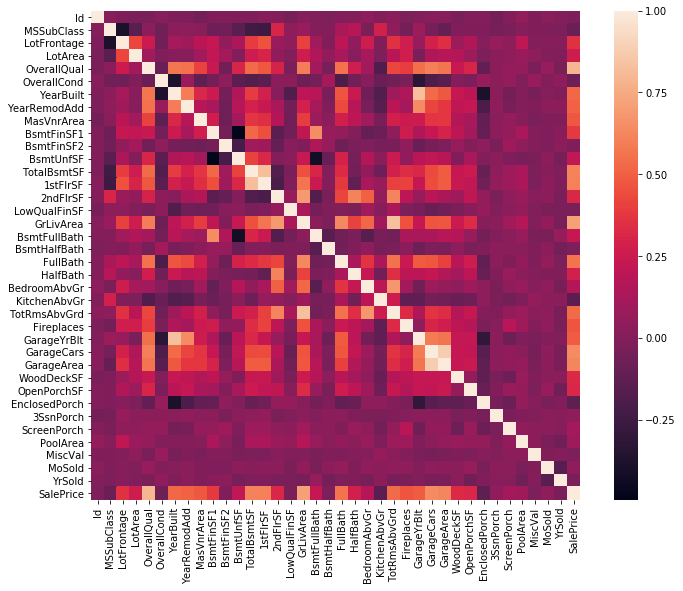

In [5]:
correlation = train_dataset.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(correlation, square=True)

The heatmap above is a good way to see the correlation between many different variables. Squares that are closer to white show that the variables are correlated. For example, in this heatmap it is possible to see that Garage cars is very correlated with garage area, which makes sense as the bigger the garage the greater the number of cars that could be fit in.

Other variables showing a strong positive correlation is TotalBsmtSf and 1stFlrSqFt

# Catagorical Data

Using Boxplots it is possible to show how SalePrice is affected by catagorical Data.

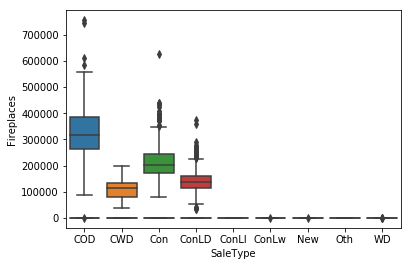

In [6]:
boxplot("KitchenQual", "SalePrice")
boxplot("SaleType", "Fireplaces")

In [7]:
train_ID = train_dataset['Id']
test_ID = test_dataset['Id']


# Now the ID column can be dropped as it is not necessary for the prediction process
train_dataset.drop('Id', axis = 1, inplace = True)
test_dataset.drop('Id', axis = 1, inplace = True)

print("\nThe train dataset size after dropping Id feature is: ", train_dataset.shape)
print("\nThe test dataset size after dropping Id feature is: ", test_dataset.shape)



The train dataset size after dropping Id feature is:  (1460, 80)

The test dataset size after dropping Id feature is:  (1459, 79)


# Cleaning the data:

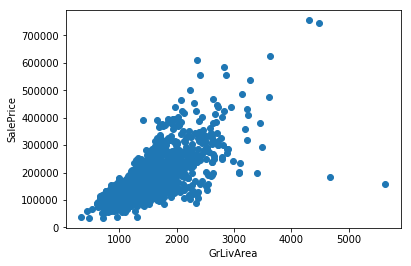

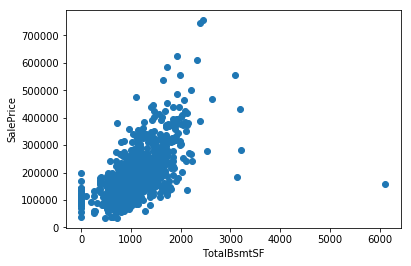

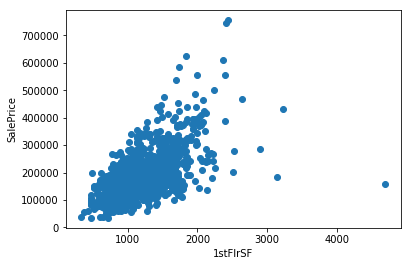

In [8]:
scatter('SalePrice', 'GrLivArea')
scatter('SalePrice', 'TotalBsmtSF')
scatter('SalePrice', '1stFlrSF')

From these graphs it can be seen that there is two major outliers, with a large living area with low price. These can be removed from the dataset. It also could be said that the two values with sales price > 700000 could be outliers, however these follow the trend line so should remain

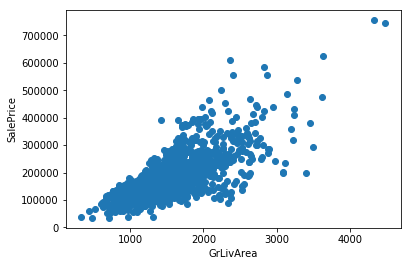

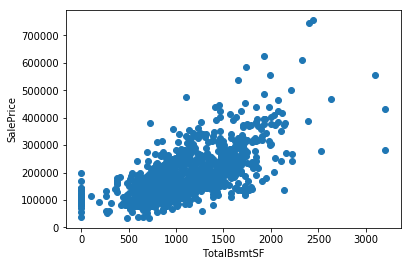

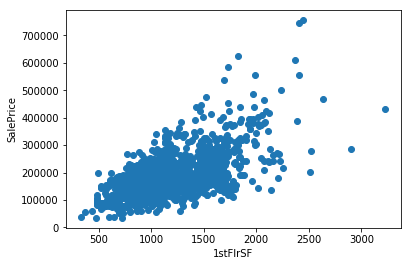

In [9]:
train_dataset = train_dataset.drop(train_dataset[(train_dataset['GrLivArea']>4000) & (train_dataset['SalePrice']<300000)].index)

# Ensure these have been deleted
scatter('SalePrice', 'GrLivArea')
scatter('SalePrice', 'TotalBsmtSF')
scatter('SalePrice', '1stFlrSF')

Earlier we saw that the target variable (y) is positively skewed. Linear models prefer to work with normally distributed data, therefore we must transform it. A log function is a useful way to transform positively skewed data 

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


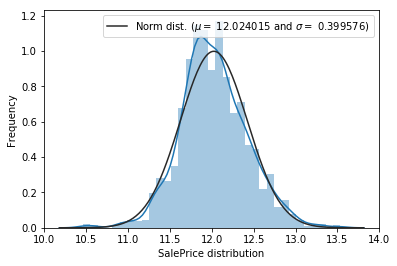

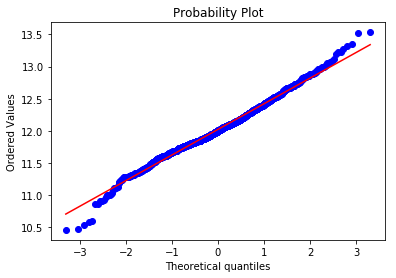

In [10]:
train_dataset["SalePrice"] = np.log1p(train_dataset["SalePrice"])

#Check to see if the data is now normally skwewed
sns.distplot(train_dataset['SalePrice'], fit=norm);

(mu, sigma) = norm.fit(train_dataset['SalePrice'])

plt.legend(['Norm dist. ($\mu=$ {:2f} and $\sigma=$ {:2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.xlabel('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_dataset['SalePrice'], plot=plt)
plt.show()

The data is now closer to being normally distributed

Before begining the data cleanup process, it is a good idea to concatenate the two datasets (test and train) so that any operations applied is applied to the entire dataset.

In [11]:
y_train = train_dataset.SalePrice.values

combined_data = pd.concat((train_dataset, test_dataset), keys=["train", "test"], sort=False)
combined_data.drop(['SalePrice'], axis=1, inplace = True)
print("combined_data size is:", combined_data.shape)

combined_data size is: (2917, 79)


# Dealing with missing values:

In [12]:
#Determines the missing values from the test dataset
# and shows which columns have at least one missing value.
total = combined_data.isnull().sum().sort_values(ascending = False) [combined_data.isnull().sum().sort_values(ascending = False) != 0]
percent = round(combined_data.isnull().sum().sort_values(ascending = False)/len(combined_data)*100,2)[round(combined_data.isnull().sum().sort_values(ascending = False)/len(combined_data)*100,2) != 0]
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(100)

,Total,Percent
PoolQC,2908,99.69
MiscFeature,2812,96.40
Alley,2719,93.21
Fence,2346,80.43
FireplaceQu,1420,48.68
LotFrontage,486,16.66
GarageCond,159,5.45
GarageQual,159,5.45
GarageYrBlt,159,5.45
GarageFinish,159,5.45


Text(0.5,1,'Percent missing data by feature')

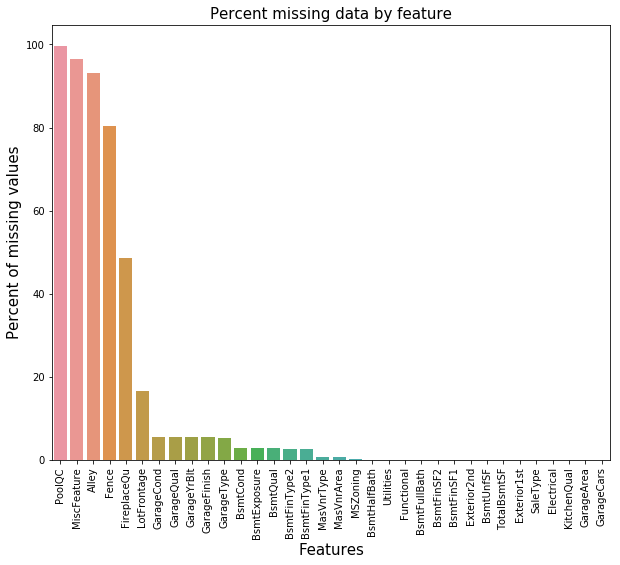

In [13]:
f, ax = plt.subplots(figsize=(10,8))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y = missing_data['Percent'])
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Dealing with missing values

In [14]:


# Misc Feature: data description says NA means no misc features
combined_data["MiscFeature"] = combined_data["MiscFeature"].fillna("None")
#Alley: data description says NA means "no alley access"
combined_data["Alley"] = combined_data["Alley"].fillna("None")
#Fence: data description says NA means no fence
combined_data["Fence"] = combined_data["Fence"].fillna("None")
#FireplaceQu: data description says NA means "no fireplace"
combined_data["FireplaceQu"] = combined_data["FireplaceQu"].fillna("None")

# The data description file describes a pool quality with a missing value to mean no pool, therefore we can fill this value in with 
# none
combined_data["PoolQC"] = combined_data["PoolQC"].fillna("None")

#GarageType, GarageFinish, GarageQual and GarageCond: Each of these with a missing value means that there is no garage
garage = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]
for column in garage:
    combined_data[column] = combined_data[column].fillna("None")
    
#GarageYrBlt, GarageArea and GarageCars blank values should be replaced with 0
for column in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    combined_data[column] = combined_data[column].fillna(0)
    

# NA in any of the below columns means no basement, therefore the SF will be 0
for column in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    combined_data[column] = combined_data[column].fillna(0)

# NA for any of the below columns means no basement, therefore can be filled with the value 0
for column in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    combined_data[column] = combined_data[column].fillna("None")
    
    
# MasVnrType with value of NA means none
combined_data["MasVnrType"] = combined_data["MasVnrType"].fillna("None")
# MasVnrArea of 0 means no MasVnr
combined_data["MasVnrArea"] = combined_data["MasVnrArea"].fillna(0)


combined_data["MSZoning"] = combined_data["MSZoning"].fillna(combined_data['MSZoning'].mode()[0])


# Assumes NA value for Utilities means has all utilities (AllPub)
combined_data["Utilities"] = combined_data["Utilities"].fillna("AllPub")

#Group by neighborhood and fill in missing value by the mean value of all other houses in the same neighborhood
combined_data["LotFrontage"] = combined_data.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.mean()))


# Assumes that if no defects are noticed with the house that its functionality
# must be typical
combined_data["Functional"] = combined_data["Functional"].fillna("Typ")

combined_data["Electrical"] = combined_data["Electrical"].fillna(combined_data['Electrical'].mode()[0])

combined_data["KitchenQual"] = combined_data["KitchenQual"].fillna(combined_data['KitchenQual'].mode()[0])

combined_data["Exterior1st"] = combined_data["Exterior1st"].fillna(combined_data['Exterior1st'].mode()[0])
combined_data["Exterior2nd"] = combined_data["Exterior2nd"].fillna(combined_data['Exterior2nd'].mode()[0])


combined_data["SaleType"] = combined_data["SaleType"].fillna(combined_data['SaleType'].mode()[0])

combined_data["MSSubClass"] = combined_data["MSSubClass"].fillna("None")


In [15]:
#Determines the missing values from the test dataset
# and shows which columns have at least one missing value.
total = combined_data.isnull().sum().sort_values(ascending = False) [combined_data.isnull().sum().sort_values(ascending = False) != 0]
percent = round(combined_data.isnull().sum().sort_values(ascending = False)/len(combined_data)*100,2)[round(combined_data.isnull().sum().sort_values(ascending = False)/len(combined_data)*100,2) != 0]
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(100)

,Total,Percent


In [16]:
combined_data['MSSubClass'] = combined_data['MSSubClass'].astype('category')

combined_data['OverallCond'] = combined_data['OverallCond'].astype('category')
combined_data['OverallQual'] = combined_data['OverallQual'].astype('category')


combined_data['YrSold'] = combined_data['YrSold'].astype('category')
combined_data['MoSold'] = combined_data['MoSold'].astype('category')

In [17]:
categorical_data = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']

print(combined_data.shape)
for i in categorical_data:
    encoder = LabelEncoder()
    encoder.fit(list(combined_data[i].values))
    combined_data[i] = encoder.transform(list(combined_data[i].values))
print(combined_data.shape)

(2917, 79)
(2917, 79)


In [18]:
combined_data = pd.get_dummies(combined_data)
print(combined_data.shape)

(2917, 230)


In [19]:
train_dataset, test_dataset = combined_data.xs("train"), combined_data.xs("test")


print(train_dataset.shape)
print(test_dataset.shape)

X = train_dataset

train_X, val_X, train_y, val_y = train_test_split(X,y_train, random_state=0)


(1458, 230)
(1459, 230)


In [20]:
# Create the machine learning model linear regression
model =  LinearRegression()

# train our model with the selected training features features.
model.fit(train_X, train_y)

#Test MAE of dataset with validation data
pred_val_y = model.predict(val_X)

mae = mean_absolute_error(pred_val_y, val_y)

print("The mean average error value is:", mae)

# Predict data based on our model
final_predict = np.expm1(model.predict(test_dataset))


pd.DataFrame({'Id': test_ID, 'SalePrice': final_predict}).to_csv("output.csv", index=False)

The mean average error value is: 0.08653226156562485


In [21]:
if IN_COLAB and mounted:
     drive.flush_and_unmount()